# Riss 'rare diseases' 학술정보 스크래핑 data
- 방법 1) 주제어 뽑아서 topic 분류 후 지도학습 / 의미있는 topic분류가 안된다면
- 방법 2) 수동 분류 index 부여해서 지도학습

In [111]:
import pandas as pd
import numpy as np

In [112]:
df_Riss_research = pd.read_csv("./csv/Seleniums.eng_academic_research2.csv")
df_Riss_research.drop(labels='_id', axis=1, inplace=True)
df_Riss_research

,research_title,research_url,research_author,research_institution,research_name,research_volumn,research_year,research_language,research_subject,research_type,research_page
0,Collaboration through the Asia Pacific MPS Net...,https://www.riss.kr/link?id=A102412091,"Cho, Sung Yoon",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,Mucopolysaccharidosis ; Rare diseases ; APMN...,학술저널,
1,Journal of Mucopolysaccharidosis and Rare Dise...,https://www.riss.kr/link?id=A102412090,"Jin, Dong-Kyu",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.1 No.1 [2015],2015,English,,학술저널,
2,Rare Presentation of an Uncommon Disease = Rar...,https://www.riss.kr/link?id=A108105268,( Vikas Marwah ) ; ( Shrinath Vasudevan ) ; ...,대한결핵 및 호흡기학회,Tuberculosis and Respiratory Diseases,Vol.85 No.2 [2022],2022,-,,학술저널,
3,Newborn Screening for Lysosomal Storage Diseas...,https://www.riss.kr/link?id=A103296772,"Lin, Hsiang-Yu ; Chuang, Chih-Kuang ; Lin, S...",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Enzyme replacement therapy ; Fluorimetry ; H...,학술저널,
4,Newborn Screening of Lysosomal Storage Disease...,https://www.riss.kr/link?id=A103296779,"Kim, Su Jin",Association for Research of MPS and Rare Diseases,Journal of mucopolysaccharidosis and rare disease,Vol.3 No.1 [2017],2017,English,Newborn screening ; Lysosomal storage disease...,학술저널,
...,...,...,...,...,...,...,...,...,...,...,...
14656,종례 : 만성내장질환 환자에서 발생한 십이지장 및 공장의 허혈성 장염 1예 = Ca...,https://www.riss.kr/link?id=A60094700,김건민 ( Gun Min Kim ) ; 김용철 ( Yong Cheol Kim ) ...,대한내과학회,대한내과학회지 (The Korean Journal of Medicine),Vol.82 No.6 [2012],2012,-,내장순환 ; 허혈 ; 십이지장염 Splanchnic circulation ; ...,학술저널,
14657,Non-Tuberculous Mycobacterium Induced Pseudoan...,https://www.riss.kr/link?id=A103555339,이해영 (고신대학교) ; 조성호 (고신대학교) ; 김현수 (고신대학교 의과대학 ...,대한흉부외과학회,Journal of Chest Surgery (J Chest Surg)(The Ko...,Vol.49 No.6 [2016],2016,English,1. Carotid arteries 2. Infection 3. Nontubercu...,학술저널,
14658,장기간 항갑상선제 투여 후 임의 중단 뒤 재복용시 발생한 무과립구증 1 예 = A ...,https://www.riss.kr/link?id=A99535412,김승만;김태영;박수영;배영환;서영경 정은주;김태균;권민정;박정현;이순희 (인제대학교...,인제대학교,仁濟醫學(Inje medical journal),Vol.32 No.- [2011],2011,Korean,Agranulocytosis ; Antithyroid agents,학술저널,
14659,HCC : PE-073 ; Synchronous development of intr...,https://www.riss.kr/link?id=A100021711,( Kyung Hyun Cheon ) ; ( Kyu Sik Jung ) ; ( ...,대한간학회(The Korean Association for the Study of ...,춘·추계 학술대회 (KASL)(N/A),Vol.2012 No.1 [2012],2012,Korean,Hepatocellular carcinoma ; Intrahepatic chola...,학술저널,


# 주제어 뽑아서 topic 분류 후 지도학습

## 데이터 전처리

### dataframe 내 중복되는 학술정보 제거

In [113]:
df_Riss_research['research_title'].value_counts()

research_title
Clinical characterization of a Korean case with 3p25 deletion                                                         4
Diagnostic Tools of Pleural Effusion                                                                                  3
Identification of a novel frameshift mutation (L345Sfs*15) in a Korean neonate with methylmalonic acidemia            3
Squamous cell carcinoma of the maxillary sinus mimicking periodontitis                                                3
戶名을 통해 본 19세기 職役과 率下奴婢 = Occupations and Domestic Slaves Seen through the Practice of household title                 3
                                                                                                                     ..
비특이적 슬관절 활액막염에 의한 다발성 미립체 = A Case of Multiple Rice Bodies by the Nonspecific Synovitis in the Knee Joint             1
췌장에 전이된 폐 소세포암 = Metastatic Small Cell Carcinoma of the Pancreas Originating from the Lung                            1
스티븐스존슨증후군의 형태로 발생한 전신홍반루푸

In [114]:
df_Riss_research.drop_duplicates(subset="research_title", keep='first', inplace=True)
df_Riss_research['research_title'].value_counts()
# 중복값 제거 완료 확인

research_title
팬데믹 상황에서의 관계적 돌봄: 파킨슨증 아버지의 돌봄 사례를 중심으로                                                                                                                                                                                                                                                                                1
Collaboration through the Asia Pacific MPS Network (APMN), Asia Pacific MPS Registry (APMR), and Association for Research of MPS & Rare Diseases (ARMRD) = Collaboration through the Asia Pacific MPS Network (APMN), Asia Pacific MPS Registry (APMR), and Association for Research of MPS & Rare Diseases (ARMRD)    1
Journal of Mucopolysaccharidosis and Rare Diseases: Launch Editorial                                                                                                                                                                                                                                                   1
Rare Presentation of an Uncommon Disease = Rar

In [115]:
df_Riss_research.reset_index(drop=True, inplace=True)

### 영문 text만 남기기

In [116]:
import re
def no_korean(text):
    patterns = '([가-힣]|[一-龥]|[0-9]|[;])'
    text_regex = re.sub(pattern=patterns, repl="", string=text)
    return text_regex
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].apply(no_korean)

### 대문자 -> 소문자

In [117]:
df_Riss_research['research_subject'] = df_Riss_research['research_subject'].str.lower()

### 불용어 제거

In [118]:
f=open('./csv/eng_academic_research_stopwords.txt')
stopwords=[]
lines = f.readlines()
for line in lines:
    line = line.strip()
    stopwords.append(line)
f.close()

### Tfidfvectorizer

In [119]:
eng_subject = df_Riss_research['research_subject'].tolist()
eng_subject = ' '.join(eng_subject).split()
eng_subject

['mucopolysaccharidosis',
 'rare',
 'diseases',
 'apmn',
 'apmr',
 'armrd',
 'enzyme',
 'replacement',
 'therapy',
 'fluorimetry',
 'hematopoietic',
 'stem',
 'cell',
 'transplantation',
 'lysosomal',
 'storage',
 'disease',
 'newborn',
 'screening',
 'tandem',
 'mass',
 'spectrometry',
 'newborn',
 'screening',
 'lysosomal',
 'storage',
 'disease',
 'mucopolysacchariodis',
 'skin',
 'barrier',
 'filaggrin',
 'atopic',
 'dermatitis',
 'epidermolysis',
 'bullosa',
 'keratin',
 'genodermatoses',
 'idiopathic',
 'pulmonary',
 'fibrosis',
 'interstitial',
 'pneumonia',
 'pathological',
 'phenotype',
 'progressive',
 'fibrosis',
 'adenocarcinoma',
 'thymus',
 'concurrent',
 'chemoradiotherapies',
 'solitary',
 'fibrous',
 'tumors',
 'pleura',
 'lipoma',
 'bronchial',
 'neoplasms',
 'carcinoma',
 'lung',
 'peritoneal',
 'dialysis',
 'pleuroperitoneal',
 'communication',
 'peritoneography',
 'pleural',
 'effusion',
 'pd',
 'catheter',
 'mucopolysaccharidoses',
 'enzyme',
 'replacement',
 'the

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(stop_words=stopwords
                                  , ngram_range=(1,2)
                                  , max_df=0.90
                                  , min_df=10) 
result_vectors = tfidfVectorizer.fit_transform(eng_subject)
result_vectors.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
tfidfVectorizer.vocabulary_ 

{'mucopolysaccharidosis': 824,
 'enzyme': 407,
 'replacement': 1106,
 'therapy': 1267,
 'hematopoietic': 541,
 'stem': 1207,
 'cell': 202,
 'transplantation': 1298,
 'lysosomal': 756,
 'storage': 1219,
 'newborn': 892,
 'screening': 1147,
 'mass': 776,
 'skin': 1183,
 'atopic': 115,
 'dermatitis': 324,
 'epidermolysis': 412,
 'bullosa': 172,
 'idiopathic': 602,
 'pulmonary': 1070,
 'fibrosis': 460,
 'interstitial': 655,
 'pneumonia': 1020,
 'phenotype': 1001,
 'progressive': 1057,
 'adenocarcinoma': 18,
 'thymus': 1280,
 'solitary': 1191,
 'fibrous': 461,
 'tumors': 1314,
 'pleura': 1014,
 'lipoma': 726,
 'bronchial': 166,
 'neoplasms': 872,
 'carcinoma': 185,
 'lung': 740,
 'peritoneal': 992,
 'dialysis': 335,
 'pleural': 1015,
 'effusion': 382,
 'pd': 976,
 'catheter': 196,
 'intractable': 663,
 'social': 1188,
 'media': 781,
 'exome': 432,
 'sequencing': 1163,
 'whole': 1378,
 'genome': 501,
 'rna': 1126,
 'gene': 494,
 'gallbladder': 483,
 'tubular': 1312,
 'adenoma': 20,
 'papilla

### K-means & Elbow method & prediction_strength 활용해서 최적 분류 수 찾기

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [125]:
# 클러스터 개수 범위 설정
min_clusters = 1
max_clusters = 10

In [126]:
# 각 클러스터 개수에 따른 SSE 값 저장
sse = []

In [127]:
# 클러스터링 수행 및 SSE 계산
for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(result_vectors)
    sse.append(kmeans.inertia_)

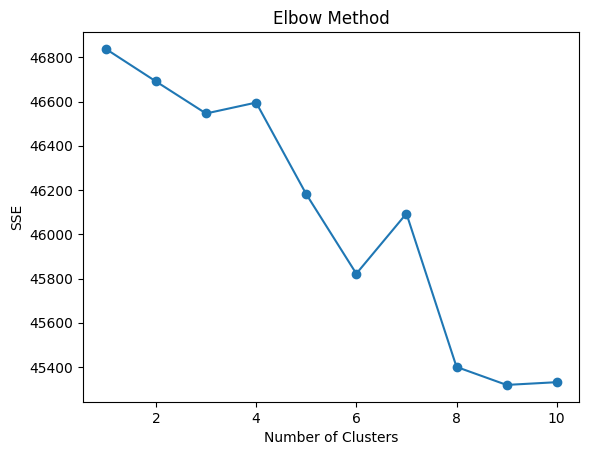

In [128]:
plt.plot(range(min_clusters, max_clusters+1), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()
# 유의미하지 않아 Prediction Strength로 최적군집수 재확인

In [129]:
from sklearn.metrics import pairwise_distances
from sklearn.utils import shuffle

In [130]:
def prediction_strength(X, n_clusters, n_runs=10):
    all_labels = []
    for _ in range(n_runs):
        # 데이터를 무작위로 섞음
        X_shuffled = shuffle(X, random_state=10)
        
        # K-means 클러스터링 실행
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(X_shuffled)
        all_labels.append(labels)
    
    all_labels = np.array(all_labels)
    pairwise_similarities = pairwise_distances(all_labels, metric='jaccard')
    prediction_strengths = pairwise_similarities.mean(axis=0)
    
    return prediction_strengths

# 데이터
X = result_vectors

# Prediction Strength 계산
n_clusters = 5
strengths = prediction_strength(X, n_clusters)
print(strengths)

[0.49646644 0.89258244 0.49623719 0.496491   0.49617169 0.89765974
 0.49617579 0.8970219  0.89755518 0.89376743]


/usr/local/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### LDA : topic 모델링

In [150]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=6, n_jobs=-1, random_state=10) # Prediction Strength로 확인한 최적 군집수 = 4
lda_model.fit(result_vectors)

LatentDirichletAllocation(n_components=6, n_jobs=-1, random_state=10)

In [151]:
dictionary_list = tfidfVectorizer.get_feature_names_out()
dictionary_list

array(['abdomen', 'abdominal', 'abducens', ..., 'young', 'zone', 'zoster'],
      dtype=object)

In [152]:
lda_model.components_

array([[34.16664279,  0.1666709 ,  0.16675428, ...,  0.16667103,
         0.16667094,  0.16667101],
       [ 0.16667133, 72.16664418, 10.97477413, ..., 28.683229  ,
        22.16664394,  0.16669334],
       [ 0.16667149,  0.16667125,  0.16667149, ...,  0.1666714 ,
         0.1666713 , 63.49200459],
       [ 0.16667133,  0.16667109,  0.16667133, ...,  0.16667123,
         0.16667114,  0.1668201 ],
       [ 0.16667184,  0.16667158,  0.16667183, ...,  0.16667173,
         0.16667163,  0.16667171],
       [ 0.16667123,  0.166671  ,  0.16667122, ...,  0.16674649,
         0.16667104,  0.16667112]])

In [153]:
topics_output = lda_model.transform(result_vectors)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score

,0,1,2,3,4,5
0,0.083333,0.583333,0.083333,0.083333,0.083334,0.083333
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
...,...,...,...,...,...,...
72239,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
72240,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
72241,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333
72242,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [154]:
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1)
df_topics_score['research_subject'] = df_Riss_research['research_subject']
df_topics_score

,0,1,2,3,4,5,dominant_topic_number,research_subject
0,0.083333,0.583333,0.083333,0.083333,0.083334,0.083333,1,mucopolysaccharidosis rare diseases apmn ...
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,enzyme replacement therapy fluorimetry hem...
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,newborn screening lysosomal storage disease ...
...,...,...,...,...,...,...,...,...
72239,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,NaN
72240,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,NaN
72241,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333,3,NaN
72242,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,NaN


In [155]:
df_topics_score.dropna(inplace=True)
df_topics_score

,0,1,2,3,4,5,dominant_topic_number,research_subject
0,0.083333,0.583333,0.083333,0.083333,0.083334,0.083333,1,mucopolysaccharidosis rare diseases apmn ...
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,enzyme replacement therapy fluorimetry hem...
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,newborn screening lysosomal storage disease ...
...,...,...,...,...,...,...,...,...
14133,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,hepatocellular carcinoma intrahepatic cholan...
14134,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,splanchnic circulation ischemia duo...
14135,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,. carotid arteries . infection . nontuberculou...
14136,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333,3,agranulocytosis antithyroid agents


### topic별 word 추출

In [169]:
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T
    df_topics = df_topics.sort_values(0, ascending=False)
    topics_text = ' '.join(df_topics[1].values[:10])
    print(topics_text)
    topics_list.append(topics_text)

topics_list_add = [['Topic0', 'Topic1', 'Topic2', 'Topic3'], topics_list]
df_topics_keywords = pd.DataFrame(topics_list_add)
df_topics_keywords = df_topics_keywords.T
df_topics_keywords

neoplasms cancer pulmonary liver metastasis therapy tuberculosis abscess aneurysm computed
cell carcinoma acute lupus transplantation treatment thrombosis nerve crohn squamous
lymphoma artery tomography thyroid resonance virus heart failure colitis idiopathic
tumor renal chronic breast magnetic primary fistula surgery infarction erythematosus
neoplasm kidney systemic sinus hepatitis malignant gland leukemia factor pneumonia
lung congenital multiple cyst imaging infection drug coronary spinal autoimmune


,0,1
0,Topic0,neoplasms cancer pulmonary liver metastasis th...
1,Topic1,cell carcinoma acute lupus transplantation tre...
2,Topic2,lymphoma artery tomography thyroid resonance v...
3,Topic3,tumor renal chronic breast magnetic primary fi...
4,None,neoplasm kidney systemic sinus hepatitis malig...
5,None,lung congenital multiple cyst imaging infectio...


### LDA 시각화

In [171]:
import pyLDAvis
import pyLDAvis.lda_model

In [172]:
vis = pyLDAvis.lda_model.prepare(lda_model, result_vectors, tfidfVectorizer)

In [173]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### topic 분류별 data 수

In [174]:
pivot_table = pd.pivot_table(data=df_topics_score,
               values='research_subject',
               index='dominant_topic_number',
               aggfunc='count')

In [175]:
pivot_table

,research_subject
dominant_topic_number,
0,6591
1,1478
2,1462
3,1481
4,1420
5,1706


### topic 파악하기

In [176]:
index_0 = df_topics_score.query('dominant_topic_number==0').index
index_1 = df_topics_score.query('dominant_topic_number==1').index
index_2 = df_topics_score.query('dominant_topic_number==2').index
index_3 = df_topics_score.query('dominant_topic_number==3').index

In [177]:
for i in range(len(df_topics_score)):
    if i in index_0:    
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[0,1]
    elif i in index_1:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[1,1]
    elif i in index_2:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[2,1]
    elif i in index_3:
        df_topics_score.loc[i,"topic_keywords"]= df_topics_keywords.loc[3,1]
df_topics_score

,0,1,2,3,4,5,dominant_topic_number,research_subject,topic_keywords
0,0.083333,0.583333,0.083333,0.083333,0.083334,0.083333,1,mucopolysaccharidosis rare diseases apmn ...,cell carcinoma acute lupus transplantation tre...
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,,neoplasms cancer pulmonary liver metastasis th...
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,,neoplasms cancer pulmonary liver metastasis th...
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,enzyme replacement therapy fluorimetry hem...,neoplasms cancer pulmonary liver metastasis th...
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,newborn screening lysosomal storage disease ...,neoplasms cancer pulmonary liver metastasis th...
...,...,...,...,...,...,...,...,...,...
14133,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,hepatocellular carcinoma intrahepatic cholan...,neoplasms cancer pulmonary liver metastasis th...
14134,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,splanchnic circulation ischemia duo...,neoplasms cancer pulmonary liver metastasis th...
14135,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0,. carotid arteries . infection . nontuberculou...,neoplasms cancer pulmonary liver metastasis th...
14136,0.083333,0.083333,0.083333,0.583333,0.083333,0.083333,3,agranulocytosis antithyroid agents,tumor renal chronic breast magnetic primary fi...


#### topic0 : 

In [178]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==0")[:30]

,dominant_topic_number,research_subject,topic_keywords
1,0,,neoplasms cancer pulmonary liver metastasis th...
2,0,,neoplasms cancer pulmonary liver metastasis th...
3,0,enzyme replacement therapy fluorimetry hem...,neoplasms cancer pulmonary liver metastasis th...
4,0,newborn screening lysosomal storage disease ...,neoplasms cancer pulmonary liver metastasis th...
5,0,,neoplasms cancer pulmonary liver metastasis th...
8,0,skin barrier filaggrin atopic dermatitis ...,neoplasms cancer pulmonary liver metastasis th...
9,0,,neoplasms cancer pulmonary liver metastasis th...
16,0,peritoneal dialysis pleuroperitoneal communi...,neoplasms cancer pulmonary liver metastasis th...
19,0,intractable diseases rare diseases social ...,neoplasms cancer pulmonary liver metastasis th...
21,0,exome sequencing rare diseases gene discovery,neoplasms cancer pulmonary liver metastasis th...


#### topic1 : 

In [179]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==1")[:30]

,dominant_topic_number,research_subject,topic_keywords
0,1,mucopolysaccharidosis rare diseases apmn ...,cell carcinoma acute lupus transplantation tre...
12,1,adenocarcinoma thymus concurrent chemoradi...,cell carcinoma acute lupus transplantation tre...
13,1,solitary fibrous tumors pleura lipoma,cell carcinoma acute lupus transplantation tre...
46,1,face brown grayish nonconfluent self- ...,cell carcinoma acute lupus transplantation tre...
50,1,pten cowden disease epidermal nevus syndro...,cell carcinoma acute lupus transplantation tre...
57,1,,cell carcinoma acute lupus transplantation tre...
64,1,,cell carcinoma acute lupus transplantation tre...
86,1,mycobacterium kansasii pneumothorax,cell carcinoma acute lupus transplantation tre...
88,1,rare diseases knowledge bases korean gen...,cell carcinoma acute lupus transplantation tre...
89,1,chylomicron retention disease hereditary hyp...,cell carcinoma acute lupus transplantation tre...


#### topic2 : 

In [180]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==2")[:30]

,dominant_topic_number,research_subject,topic_keywords
6,2,,lymphoma artery tomography thyroid resonance v...
7,2,,lymphoma artery tomography thyroid resonance v...
10,2,,lymphoma artery tomography thyroid resonance v...
37,2,,lymphoma artery tomography thyroid resonance v...
65,2,bowen’s disease pigmented bowen’s disease,lymphoma artery tomography thyroid resonance v...
69,2,,lymphoma artery tomography thyroid resonance v...
70,2,,lymphoma artery tomography thyroid resonance v...
79,2,pleural effusion instillation methyprednis...,lymphoma artery tomography thyroid resonance v...
103,2,mucolipidosis type ii prenatal diagnosis l...,lymphoma artery tomography thyroid resonance v...
119,2,mucopolysaccharidosis iii sanfilippo syndrom...,lymphoma artery tomography thyroid resonance v...


#### topic3 : 

In [181]:
df_topics_score[["dominant_topic_number","research_subject","topic_keywords"]].query("dominant_topic_number==3")[:30]

,dominant_topic_number,research_subject,topic_keywords
17,3,,tumor renal chronic breast magnetic primary fi...
18,3,mucopolysaccharidoses enzyme replacement the...,tumor renal chronic breast magnetic primary fi...
20,3,rare diseases multi-omics exome sequencing...,tumor renal chronic breast magnetic primary fi...
22,3,multiseptate gallbladder tubular adenoma i...,tumor renal chronic breast magnetic primary fi...
23,3,de novo variants autistic disorder congeni...,tumor renal chronic breast magnetic primary fi...
33,3,salmonella serovar foodborne diseases,tumor renal chronic breast magnetic primary fi...
39,3,bronchial neoplasms carcinoma lung,tumor renal chronic breast magnetic primary fi...
43,3,vesico-ureteral reflux endoscopic injection ...,tumor renal chronic breast magnetic primary fi...
45,3,poikilodermatous mycosis fungoides,tumor renal chronic breast magnetic primary fi...
55,3,crohn disease inflammatory bowel disease e...,tumor renal chronic breast magnetic primary fi...


## 머신러닝 학습시키기